#### Example of text classification Keras' Convolutional Neural Network

Reference pages:
- https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [23]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


Text preprocessing

In [24]:
%%time
import re

text = df.Consumer_complaint_narrative

# removing XXX words
text = text.apply(lambda x: re.sub(r'X{2,}', '', x))

# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

text.head()

CPU times: user 298 ms, sys: 1.45 ms, total: 299 ms
Wall time: 299 ms


0    my   account was paid off but they have left t...
1    i had a citibank checking account which i clos...
2    i would like to request the suppression of the...
3    account from  with a balance is reporting to m...
4    the credit bureaus are reporting inaccurate/ou...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

**Preparing the input**

The `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. We can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [26]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_seqs = tokenizer.texts_to_sequences(train_sentences)
test_seqs = tokenizer.texts_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

CPU times: user 925 ms, sys: 0 ns, total: 925 ms
Wall time: 925 ms


The indexing is ordered after the most common words in the text. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which will be done in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object.

In [27]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 48
happy: 1829
sad: 3437


With Tokenizer, the resulting vectors equal the length of each text, and the resulting vectors won't have the same length. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we will to append them. Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

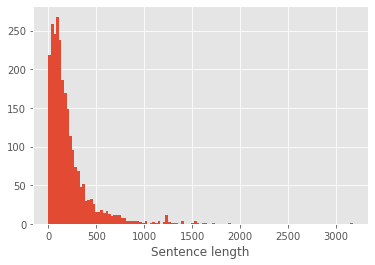

In [28]:
import matplotlib.pyplot as plt

# analyzing the sentences' length
freqs = pd.Series(train_seqs).apply(lambda x: len(x))
plt.hist(freqs, bins='auto') 
plt.xlabel('Sentence length');

In [29]:
from keras.preprocessing.sequence import pad_sequences

max_len = 250

X_train = pad_sequences(train_seqs, padding='post', maxlen=max_len)
X_test = pad_sequences(test_seqs, padding='post', maxlen=max_len)

**Creating and traning the model**

We can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector (word embedding). When inputing a sequence/document, the output of the embedding layer is a 2D vector with one embedding for each word in the input sequence of words.

- `input_dim`: the size of the vocabulary (i.e., the number of neurons).
- `output_dim`: the size of the dense vector generated by the layer.
- `input_length`: the length of the input sequence/document.

The embedding layer is followed by a convolutional layer. We will create kernels with different window sizes in the same layer (see https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/). These different sizes will work like different n-grams.

- `filters`: the number of filters/neurons/kernel in the layer. Thus, this also sets the output dimension.
- `kernel_size`: the lentgh of the convolution window. In our case, how many tokens will be processed by each filter.
- `activation`: the activation function.

After the convolutional layer, we will apply a pooling layer (`MaxPool2D`). The pool size is adjusted based on the convolutional window size.

The output of all poollings is concatenated in order to get a single 2D vector. This vector must be flattened to a 1D vector (Flatten layer) in order to be applyed as input of a dense layer.

In [30]:
from keras.models import Model
from keras import layers

filter_sizes = [1,2,3,5]
num_filters = 10
embedding_dim = 150

inp = layers.Input(shape=(max_len,))
x = layers.Embedding(input_dim=vocab_size, 
                     output_dim=embedding_dim)(inp)
x = layers.Reshape((max_len, 
                    embedding_dim, 
                    1))(x)

maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = layers.Conv2D(num_filters, 
                        kernel_size=(filter_sizes[i], embedding_dim), 
                        kernel_initializer='he_normal', 
                        activation='relu')(x)
    maxpool_pool.append(layers.MaxPool2D(pool_size=(max_len - filter_sizes[i] + 1, 1))(conv))

z = layers.Concatenate(axis=1)(maxpool_pool)   
z = layers.Flatten()(z)
z = layers.Dropout(0.1)(z)

outp = layers.Dense(5, activation="sigmoid")(z)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 250, 150)     1569450     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 250, 150, 1)  0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 250, 1, 10)   1510        reshape_4[0][0]                  
____________________________________________________________________________________________

Training the model.

In [31]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=15,
                    verbose=False,
                    validation_data=(X_test, Y_test),
                    batch_size=70)

/home/alexandre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


CPU times: user 14min 54s, sys: 7min 17s, total: 22min 11s
Wall time: 6min 14s


Evaluation.

Training Accuracy: 0.9889
Testing Accuracy:  0.8313


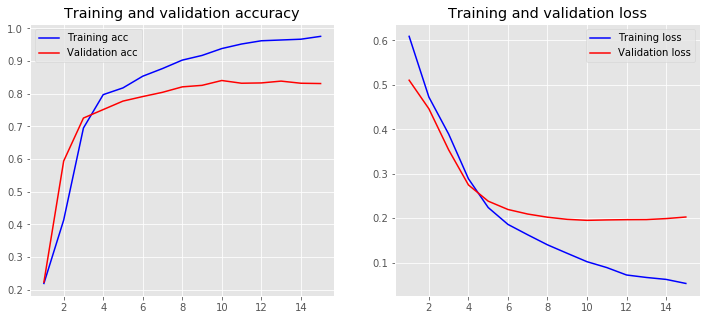

In [32]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8313253012048193
confusion matrix
 [[182  15  11   7   1]
 [ 18 166  15  12   5]
 [  5  10 184   3  13]
 [  6   7   7 187   9]
 [  4   8  19   7 178]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       216
           1       0.81      0.77      0.79       216
           2       0.78      0.86      0.82       215
           3       0.87      0.87      0.87       216
           4       0.86      0.82      0.84       216

    accuracy                           0.83      1079
   macro avg       0.83      0.83      0.83      1079
weighted avg       0.83      0.83      0.83      1079



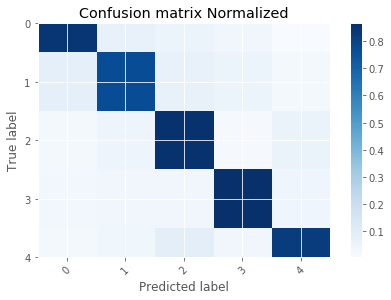

In [34]:
import numpy as np
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))